# Intro
This is a jupyter notebook containing  code relevant to finding distant pairs using BiG-SLICE features  

This code is part of the BiG-SCAPE 2.0 thesis project  

Start by importing these modules

In [1]:
import multiprocessing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plots.hist

import data
import truth.truth as truth
import input.paths as paths
import input.bigslice_hmm

import predictions
import predictions.tests

import validation

from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

import math

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [2]:

# location of the core and bio pfam information tab separated files.
# these are included in this repository, but if you want to get them from BiG-SLICE directly point them to their respective locations
CORE_PFAM_TSV = "corepfam.tsv"
BIO_PFAM_TSV = "biopfam.tsv"
# location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances.tsv"
# Base folder of Cluster files generated by BiG-SCAPE for a run. e.g:
BIGSCAPE_CLUSTER_FILES = "D:/Temp/2022-03-22_09-18-06_hybrids_global"

# location of the sqlite database to analyze
SQLITE_DB = "D:/Temp/data-benchmark-100.db"


The following code loads data from a BiG-SCAPE run. Point the RUN_PATH to a BiG-SCAPE result folder and it will collect all BGC pair distances
It will then save these distances to the bigscape_distances.tsv file indicated by the FULL_TSV path above

If you want to recreate the bigscape_distances.tsv, run BiG-SCAPE 2.0 on the closed streptomyces dataset provided here:
https://zenodo.org/record/1532752/files/Closed_Streptomyces_antiSMASH_results.zip?download=1
and run using bigscape.py --i /path/to/streptomyces -o ~/bigscape-streptomyces-output --cutoff 1.0
then uncomment and run the following code block

In [3]:
# TRUTH_DISTANCES = truth.get_distances_from_results(BIGSCAPE_CLUSTER_FILES, "1.00")
# truth.write_full_file(FULL_TSV, TRUTH_DISTANCES)

Otherwise, just run the below code block to load the ground truth for validation

In [4]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)

TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)

print("Loading stored info from database")
DB = data.Database(SQLITE_DB)

BGC_IDS = data.get_bgc_ids(DB)
HMM_IDS = data.get_hmm_ids(DB)

BGC_ID_NAME_DICT = data.get_bgc_id_name_dict(DB, True)
BGC_NAME_ID_DICT = {name: id for id, name in BGC_ID_NAME_DICT.items()}

CORE_PFAM_ACC, CORE_PFAM_NAMES = input.bigslice_hmm.get_core_pfam(CORE_PFAM_TSV)
BIO_PFAM_ACC, BIO_PFAM_NAMES = input.bigslice_hmm.get_bio_pfam(BIO_PFAM_TSV)
# get corresponding ids
CORE_PFAM_IDS = data.get_core_pfam_ids(DB, CORE_PFAM_ACC, CORE_PFAM_NAMES)
BIO_PFAM_IDS = data.get_bio_pfam_ids(DB, BIO_PFAM_ACC, BIO_PFAM_NAMES)
CORE_PFAM_SET = set(CORE_PFAM_IDS)
BIO_PFAM_SET = set(BIO_PFAM_IDS)
print("Done")
print(len(BGC_IDS), "BGCs in database")


Loading truth
Loading stored info from database
Done
2982 BGCs in database


First bit of data exploration: show a histogram of values in the truth data.
This gives a general idea of how the true distances are distributed

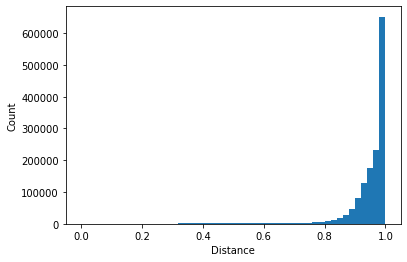

1440847 total pair distances calculated
4843 distances below 0.3


In [5]:
# show hist of true distances
plots.hist.from_distances(TRUTH_DISTANCES, max=len(TRUTH_DISTANCES), bins=50, xlab="Distance", ylab="Count")
print(len(TRUTH_DISTANCES), "total pair distances calculated")
print(len(TRUTH_PAIRS[0]), "distances below 0.3")

What this shows is that the vast majority of distances in the ground truth are way beyond the default BiG-SCAPE cutoff of 0.3
In turn this means that the vast majority of BGCs are unrelated, and if we can filter these out before we run BiG-SCAPE's pairwise distance calculation we can gain a lot of time

We are trying to use the fast calculation of BiG-SLICE features to thin out the crowd of BGC comparisons.
We will load the data into a format that can be used by skilearn, which we're using for most analyses

In [6]:

print("Instantiating dataframes")
# instantiate dataframes
FEATURES = pd.DataFrame(
    np.zeros((len(BGC_IDS), len(HMM_IDS)), dtype=np.uint8),
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
BGC_HMM_FEATURES = data.get_features(DB)
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES.at[bgc_id, hmm_id] = value
print("Done")

Instantiating dataframes
Done


We want to know more about what this data looks like. It probably helps to get data labels based on truth for visualisation if we want to do it.
We get a label set based on the distances. This probably isn't super accurate but it will give us a general idea of which data points belong together.
The labels are assembled by going through all distances and assigning pairs with distance < 0.3 to a label
If later on there is a pair where BGC A already has a label, it will set or overwrite BGC B's label with that of BGC A.
The same goes for if there is already a label set on BGC B. It will then set the label of BGC A to that of BGC B.

IF the total number of pairs / 2 is larger than the total number of BGCs, this will overwrite labels. Thus this is probably not super accurate. This data is also missing the initial separation of bgcs due to product type classification

In [69]:
# get a dataframe of labels associated with each BGC based on truth
# this means a dataframe of bgcs where bgcs with a distance of < 0.3 belong to
# the same 'cluster'
TRUTH_LABELS = validation.labels_from_distances(TRUTH_DISTANCES, BGC_NAME_ID_DICT, BGC_IDS)

LABEL_LIST = [TRUTH_LABELS.at[bgc_id,"label"] for bgc_id in BGC_IDS]
print("Found", max(TRUTH_LABELS["label"]), " labels")
# check how this measures up to the pairs in the truth data
classified = len(list(filter(lambda item: item > 0, LABEL_LIST)))
unclassified = len(LABEL_LIST) - classified
print(classified, "BGCs are labeled")
print(unclassified, "BGCs are unlabeled")
PAIRED_BGCS = set()
for pair in TRUTH_PAIRS[0]:
    PAIRED_BGCS.add(pair[0])
    PAIRED_BGCS.add(pair[1])
print(len(PAIRED_BGCS), "BGCs are actually paired")

Found 601  labels
1669 BGCs are labeled
1313 BGCs are unlabeled
1669 BGCs are actually paired


We might want to consider the features generated from core domains and biosynthetic domains seperately. There are a few ways to do this but the easiest is to make some sort of sum of the features in these two classes and create a two-dimensional data frame.

In [70]:
# this dataframe contains sums of features from biosynthetic pfams and core pfams separately
SUMS_CORE = pd.DataFrame(FEATURES[CORE_PFAM_IDS].sum(axis=1), columns=["sum_core"])
SUMS_BIO = pd.DataFrame(FEATURES[BIO_PFAM_IDS].sum(axis=1), columns=["sum_bio"])
FEATURES_SUMS = pd.merge(SUMS_CORE, SUMS_BIO, left_index=True, right_index=True)

We can look at what this data looks like using the labels from earlier

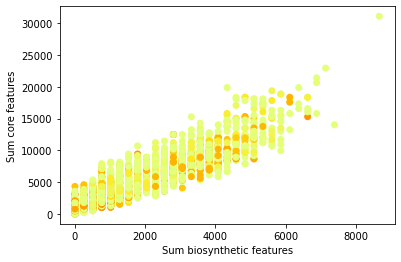

In [71]:
# show a plot of how this data looks lke
plt.xlabel("Sum biosynthetic features")
plt.ylabel("Sum core features")
plt.scatter(FEATURES_SUMS["sum_core"], FEATURES_SUMS["sum_bio"], c=LABEL_LIST, cmap="Wistia")
plt.show()

This doesn't show any clear separation of pairs using this. Then again, it's hard to tell since there are quite a lot of labels.

It's unlikely that simple summation of data is a good method of reducing dimensionality.
If we need to we can return to reducing dimensionality later

For now we will look at some things we can do in a higher dimensional space. Starting simple with euclidean distance calculation. The following calculates euclidean distances on all rows and features and plots the distances calculated in a histogram.

This is using all entries, so it may take some time.

In [72]:
EUCLIDEAN_DISTS = predictions.get_distances(FEATURES, BGC_ID_NAME_DICT, metric="euclidean")

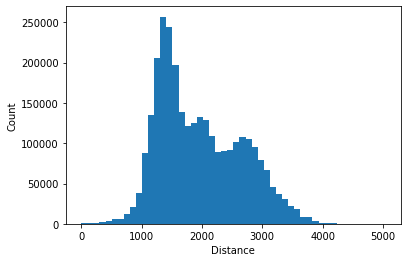

2979018 pairs in this set


In [73]:

plots.hist.from_distances(EUCLIDEAN_DISTS, max=None, bins=50, xlab="Distance", ylab="Count")
print(len(EUCLIDEAN_DISTS), "pairs in this set")

This graph does not correspond well at all to the graph we got earlier. Let's look at the correlation plot of distances:

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

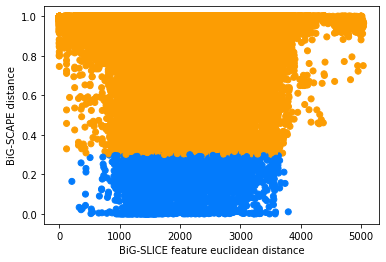

In [74]:
print("Generating distance/index dictionary")
BIGSCAPE_EUCLID_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    BIGSCAPE_EUCLID_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in EUCLIDEAN_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # not all BGCs have features
    if pair_key not in BIGSCAPE_EUCLID_DICT:
        continue
    # ignore duplicates
    if (len(BIGSCAPE_EUCLID_DICT[pair_key]) == 1):
        BIGSCAPE_EUCLID_DICT[pair_key].append(dist)

scatter_x = []
scatter_y = []
scatter_color = []
for i, item in BIGSCAPE_EUCLID_DICT.items():
    # again, not all bgcs had features, but they may be present in the dict
    if len(item) == 1:
        continue
    dist, idx = item
    scatter_x.append(idx)
    scatter_y.append(dist)
    if dist < 0.3:
        scatter_color.append("#037bfc")
    else:
        scatter_color.append("#fc9d03")

plt.scatter(scatter_x, scatter_y, c=scatter_color)
plt.xlabel("BiG-SLICE feature euclidean distance")
plt.ylabel("BiG-SCAPE distance")

The correlation plot shows no clear correlation, so it is unlikely that we can equate high or low values with distant or closely related BGCs.  

Still, there seems to be a range of distances where BiG-SCAPE distances are never under 0.3. We can look at some cutoffs to see what we get out of these ranges

In [75]:
results_upper = predictions.tests.distance.run_upper(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    upper_range=20,
    upper_cutoff_step=200,
    upper_cutoff_start=1000
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
1000,0,2338752,45898,NA,0.0,1.0,0.996,NA,0.996,0,0,710303,2620
1200,0,2236930,147720,NA,0.0,1.0,0.996,NA,0.996,0,0,678552,2481
1400,0,2000448,384202,NA,0.0,1.0,0.996,NA,0.996,0,0,606011,2163
1600,0,1695393,689257,NA,0.0,1.0,0.996,NA,0.996,0,0,513662,1811
1800,0,1443159,941491,NA,0.0,1.0,0.996,NA,0.996,0,0,434735,1554
2000,0,1197316,1187334,NA,0.0,1.0,0.996,NA,0.996,0,0,361076,1297
2200,0,960214,1424436,NA,0.0,1.0,0.996,NA,0.996,0,0,290821,1028
2400,0,793047,1591603,NA,0.0,1.0,0.996,NA,0.996,0,0,241453,877
2600,0,624307,1760343,NA,0.0,1.0,0.996,NA,0.996,0,0,190750,689
2800,0,428750,1955900,NA,0.0,1.0,0.996,NA,0.996,0,0,132655,480
3000,0,259111,2125539,NA,0.0,1.0,0.997,NA,0.997,0,0,81731,284
3200,0,141922,2242728,NA,0.0,1.0,0.997,NA,0.997,0,0,43158,144
3400,0,70929,2313721,NA,0.0,1.0,0.996,NA,0.996,0,0,20641,81
3600,0,26903,2357747,NA,0.0,1.0,0.998,NA,0.998,0,0,7213,13
3800,0,9931,2

Lower end:

In [76]:

results_lower = predictions.tests.distance.run_lower(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    lower_range=20,
    lower_cutoff_start=100,
    lower_cutoff_step=100,
    invert=True
)

Predictions from distances (lower only):
cut_low,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
100,0,638,2384012,NA,NA,1.0,1.0,NA,1.0,0,0,187,0
200,0,1244,2383406,NA,NA,1.0,1.0,NA,1.0,0,0,396,0
300,0,1994,2382656,NA,0.0,1.0,0.998,NA,0.998,0,0,636,1
400,0,3264,2381386,NA,0.0,1.0,0.995,NA,0.995,0,0,1057,5
500,0,5198,2379452,NA,0.0,1.0,0.995,NA,0.995,0,0,1664,9
600,0,7986,2376664,NA,0.0,1.0,0.995,NA,0.995,0,0,2485,13
700,0,11055,2373595,NA,0.0,1.0,0.996,NA,0.996,0,0,3382,15
800,0,16900,2367750,NA,0.0,1.0,0.995,NA,0.995,0,0,5109,27
900,0,26078,2358572,NA,0.0,1.0,0.996,NA,0.996,0,0,7844,34
1000,0,45898,2338752,NA,0.0,1.0,0.994,NA,0.994,0,0,13841,77
1100,0,83126,2301524,NA,0.0,1.0,0.995,NA,0.995,0,0,25538,125
1200,0,147720,2236930,NA,0.0,1.0,0.995,NA,0.995,0,0,45592,216
1300,0,249801,2134849,NA,0.0,1.0,0.995,NA,0.995,0,0,76979,364
1400,0,384202,2000448,NA,0.0,1.0,0.996,NA,0.996,0,0,118133,534
1500,0,536843,1847807,NA,0.0,1.0,0.996,NA,0.996,0,0,164056,712
1600,0,689257,1695393,NA,

Collating all the above results into one plot for the report:

Text(-0.15, 1.0, 'D')

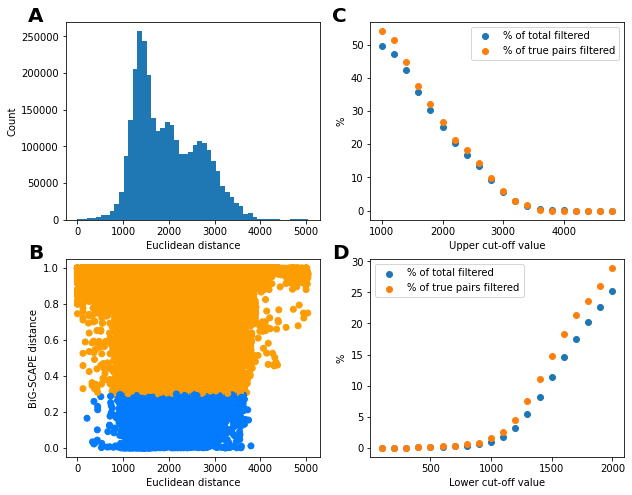

In [77]:
x_upper = []
x_lower = []
y1_upper = []
y2_upper = []
y1_lower = []
y2_lower = []

# get results for upper cutoffs into arrays
for result_upper in results_upper:
    cutoff, tp, fp, tn, fn = result_upper
    # get % of total pairs filtered out
    perc_filtered = (tn+fn)/len(TRUTH_DISTANCES) * 100
    # get % of incorrectly filtered pairs
    perc_incorrect = fn/len(TRUTH_PAIRS[0]) * 100
    x_upper.append(cutoff)
    
    y1_upper.append(perc_filtered)
    y2_upper.append(perc_incorrect)

# get results for lower cutoffs into arrays
for result_lower in results_lower:
    cutoff, tp, fp, tn, fn = result_lower
    # get % of total pairs filtered out
    perc_filtered = (tn+fn)/len(TRUTH_DISTANCES) * 100
    # get % of incorrectly filtered pairs
    perc_incorrect = fn/len(TRUTH_PAIRS[0]) * 100
    x_lower.append(cutoff)
    
    y1_lower.append(perc_filtered)
    y2_lower.append(perc_incorrect)

# get subplots
fig, axes = plt.subplots(2, 2)
# resize
fig.set_size_inches(10, 8)

freq_ax = axes[0, 0] # top left
scatter_ax = axes[1, 0] # bottom left
upper_ax = axes[0, 1] # top right
lower_ax = axes[1, 1] # bottom right

# freq plot
distances = []
for idx, distance_entry in enumerate(EUCLIDEAN_DISTS):
    if idx == max:
        break
    distances.append(distance_entry[2])

freq_ax.hist(distances, bins=50)

freq_ax.set_xlabel("Euclidean distance")
freq_ax.set_ylabel("Count")
freq_ax.text(-0.15, 1.0, "A", transform=freq_ax.transAxes,
            size=20, weight='bold')


# scatter plot
scatter_ax.scatter(scatter_x, scatter_y, c=scatter_color)
scatter_ax.set_xlabel("Euclidean distance")
scatter_ax.set_ylabel("BiG-SCAPE distance")
scatter_ax.text(-0.15, 1.0, "B", transform=scatter_ax.transAxes,
            size=20, weight='bold')

# upper cutoff stats
upper_filter_line = upper_ax.scatter(x_upper, y1_upper)
upper_incorrect_line = upper_ax.scatter(x_upper, y2_upper)
upper_ax.legend([upper_filter_line, upper_incorrect_line], ["% of total filtered", "% of true pairs filtered"])
upper_ax.set_ylabel("%")
upper_ax.set_xlabel("Upper cut-off value")
upper_ax.text(-0.15, 1.0, "C", transform=upper_ax.transAxes,
            size=20, weight='bold')

# lower cutoff stats
lower_filter_line = lower_ax.scatter(x_lower, y1_lower)
lower_incorrect_line = lower_ax.scatter(x_lower, y2_lower)
lower_ax.legend([lower_filter_line, lower_incorrect_line], ["% of total filtered", "% of true pairs filtered"])
lower_ax.set_ylabel("%")
lower_ax.set_xlabel("Lower cut-off value")
lower_ax.text(-0.15, 1.0, "D", transform=lower_ax.transAxes,
            size=20, weight='bold')

The amount of pairs we filter out using this method is very low.  
we will have to find a better way of eliminating pairs than calculating a simple euclidean distance

We can try a different metric, like cosine similarity

In [78]:
COSINE_DISTS = predictions.get_cosine_distance(FEATURES, BGC_ID_NAME_DICT)

print(len(COSINE_DISTS), "pairs in cosine dists")

4444671 pairs in cosine dists


In [7]:
COSINE_DISTS = []

cosine_similarities = cosine_similarity(FEATURES.sort_index(inplace=False))

for idx, dist_item in enumerate(TRUTH_DISTANCES):
    bgc_name_a, bgc_name_b, dist = dist_item
    bgc_id_a = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_id_b = BGC_NAME_ID_DICT[bgc_name_b]
    dist = 1 - cosine_similarities[bgc_id_a - 1, bgc_id_b - 1]
    COSINE_DISTS.append([bgc_name_a, bgc_name_b, dist])


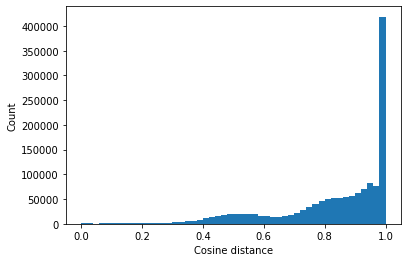

1440847 pairs in cosine dists


In [80]:
# plot
plots.hist.from_distances(COSINE_DISTS, max=None, bins=50, xlab="Cosine distance", ylab="Count")
print(len(COSINE_DISTS), "pairs in cosine dists")

This looks a lot more similar to the truth distances calculated earlier. Correlation plot:

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

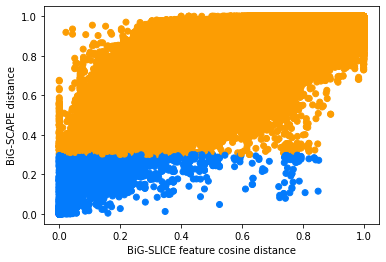

In [81]:
print("Generating distance/index dictionary")
BIGSCAPE_COSINE_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    BIGSCAPE_COSINE_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in COSINE_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # not all BGCs have features
    if pair_key not in BIGSCAPE_COSINE_DICT:
        continue
    # ignore duplicates
    if (len(BIGSCAPE_COSINE_DICT[pair_key]) == 1):
        BIGSCAPE_COSINE_DICT[pair_key].append(dist)

x = []
y = []
l = []
for i, item in BIGSCAPE_COSINE_DICT.items():
    # again, not all bgcs had features, but they may be present in the dict
    if len(item) == 1:
        continue
    dist, idx = item
    x.append(idx)
    y.append(dist)
    if dist < 0.3:
        l.append("#037bfc")
    else:
        l.append("#fc9d03")

plt.scatter(x, y, c=l)
plt.xlabel("BiG-SLICE feature cosine distance")
plt.ylabel("BiG-SCAPE distance")

We know that the majority of pairs have a high cosine distance, and we can see that everything above a cosine distance of 0.7-0.8 only has a few data points that should not be excluded  

Looks like we can exclude pairs this way then. Let's try some cutoffs:

In [82]:
results_upper = predictions.tests.distance.run_upper(
    COSINE_DISTS,
    TRUTH_PAIRS,
    upper_range=6,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.4
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.4,0,1306002,41645,NA,0.0,1.0,1.0,NA,1.0,0,0,1305830,172
0.5,0,1246922,100725,NA,0.0,1.0,1.0,NA,1.0,0,0,1246826,96
0.6,0,1174360,173287,NA,0.0,1.0,1.0,NA,1.0,0,0,1174292,68
0.7,0,1108690,238957,NA,0.0,1.0,1.0,NA,1.0,0,0,1108635,55
0.8,0,952862,394785,NA,0.0,1.0,1.0,NA,1.0,0,0,952855,7
0.9,0,703410,644237,NA,NA,1.0,1.0,NA,1.0,0,0,703410,0


Looks ok. Let's plot these and choose a cutoff:

(0.0, 100.0)

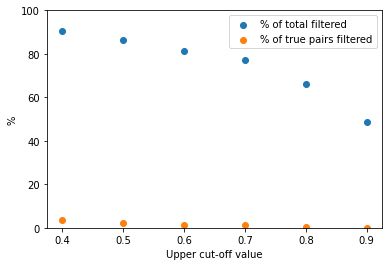

In [83]:
x_upper = []
y1_upper = []
y2_upper = []
# get results for upper cutoffs into arrays
for result_upper in results_upper:
    cutoff, tp, fp, tn, fn = result_upper
    # get % of total pairs filtered out
    perc_filtered = (tn+fn)/len(TRUTH_DISTANCES) * 100
    # get % of incorrectly filtered pairs
    perc_incorrect = fn/len(TRUTH_PAIRS[0]) * 100
    x_upper.append(cutoff)
    
    y1_upper.append(perc_filtered)
    y2_upper.append(perc_incorrect)

# upper cutoff stats
upper_filter_line = plt.scatter(x_upper, y1_upper)
upper_incorrect_line = plt.scatter(x_upper, y2_upper)
plt.legend([upper_filter_line, upper_incorrect_line], ["% of total filtered", "% of true pairs filtered"])
plt.xlabel("Upper cut-off value")
plt.ylabel("%")
plt.ylim(0, 100)

It would be nice to know which pairs we're filtering out exactly.  
there is a mechanism in BiG-SCAPE which sets totally unrelated pairs with no overlapping domains to a distance of 1.  
Let's compare if we are just filtering out the same ones with our cosine distance. After all we are doing a similar thing there

In [84]:
# probably all the pairs that are totally overlapping have a score of exactly 1.0 in BiG-SCAPE. there may be a few others but let's assume this for now
TOTAL_OVERLAPPING_PAIRS = []
for distance in TRUTH_DISTANCES:
    if distance[2] == 1.0:
        TOTAL_OVERLAPPING_PAIRS.append(distance)
print(len(TOTAL_OVERLAPPING_PAIRS), " pairs with distance=1.0 in BiG-SCAPE")

# get the cosine distances with dist = 1.0
COSINE_DIST_CORR_10 = []
for distance in COSINE_DISTS:
    if distance[2] == 1.0:
        COSINE_DIST_CORR_10.append(distance)
print(len(COSINE_DIST_CORR_10), " pairs with distance=1.0 in cosine distances")

394908  pairs with distance=1.0 in BiG-SCAPE
400820  pairs with distance=1.0 in cosine distances


This is pretty good news. We are filtering out more than BiG-SCAPE does just based on the jaccard index alone.  
Let's do the exercise one more time with a lower cutoff (0.7) since we saw a very low amount of false negatives (55)

In [85]:
# get the cosine distances with dist = 1.0
COSINE_DISTS_07 = []
for distance in COSINE_DISTS:
    if distance[2] > 0.69999999:
        COSINE_DISTS_07.append(distance)
print(len(TOTAL_OVERLAPPING_PAIRS), " pairs with distance=1.0 in BiG-SCAPE")
print(len(COSINE_DISTS_07), " pairs with distance>0.7 in cosine distances")

394908  pairs with distance=1.0 in BiG-SCAPE
1143514  pairs with distance>0.7 in cosine distances


This is almost 3 times as many pairs, with in this case very few false negatives.

Just to check, I would like to know how many of these pairs just don't have any overlap in domains

In [86]:
count = 0

BGC_HMM_IDS = {}
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    if bgc_id not in BGC_HMM_IDS:
        BGC_HMM_IDS[bgc_id] = set()
    BGC_HMM_IDS[bgc_id].add(hmm_id)

for pair in TRUTH_DISTANCES:
    bgc_name_a, bgc_name_b, truth_dist = pair
    bgc_a_id = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_b_id = BGC_NAME_ID_DICT[bgc_name_b]
    
    hmm_ids_a = BGC_HMM_IDS[bgc_a_id]
    hmm_ids_b = BGC_HMM_IDS[bgc_b_id]

    overlap = hmm_ids_a & hmm_ids_b
    # assume any with overlap 0 to be totally distant
    if len(overlap) == 0:
        count += 1
        continue

print(len(TRUTH_DISTANCES), " total pairs analyzed in BiG-SCAPE")
print(count, " pairs with no overlap according to BiG-SLICE features")
print(round(count/len(TRUTH_DISTANCES)*100, 3), "% of pairs do not have overlapping domains")
print("A total of", len(COSINE_DISTS_07), " pairs (", round(len(COSINE_DISTS_07)/len(TRUTH_DISTANCES)*100, 3), "%) will be filtered out using this method")
print(len(TRUTH_DISTANCES) - len(COSINE_DISTS_07), "pairs remain after filtering (", len(TRUTH_PAIRS[0]), "pairs in truth are under 0.3 threshold)")

1440847  total pairs analyzed in BiG-SCAPE
400820  pairs with no overlap according to BiG-SLICE features
27.818 % of pairs do not have overlapping domains
A total of 1143514  pairs ( 79.364 %) will be filtered out using this method
297333 pairs remain after filtering ( 4843 pairs in truth are under 0.3 threshold)


This would be pretty nice. Here are the statistics for this cutoff:

In [87]:
COSINE_PAIRS_CORR = validation.pairs_from_distances(COSINE_DISTS, None, 0.69999999)
validation.print_full_stats(TRUTH_PAIRS, COSINE_PAIRS_CORR)

Total pairs in truth:  1347682
Composition (T/F/U):  4843 1342839 0
Total pairs in prediction:  1347647
Composition (T/F/U):  0 1108690 238957
True positives:  0
False positives:  0
True negatives:  1108635
False negatives:  55
Precision:  0.0
Sensitivity:  0.0
Specificity:  1.0
Accuracy:  0.9999503919039587
